Je n'ai pas réussi à recoder l'algorithme PACO qui est très compliqué. J'ai donc décidé de changer un peu le package déjà codé en R afin de garder les centres et les clusters réalisés à partir de $t$ observations pour $t$ allant de 2 à $T$. Je stocke ces données dans une dataframe, et je crée maintenant une visualisation python afin de représenter le déplacement des clusters au fur et à mesure que de nouveaux points apparaissent.

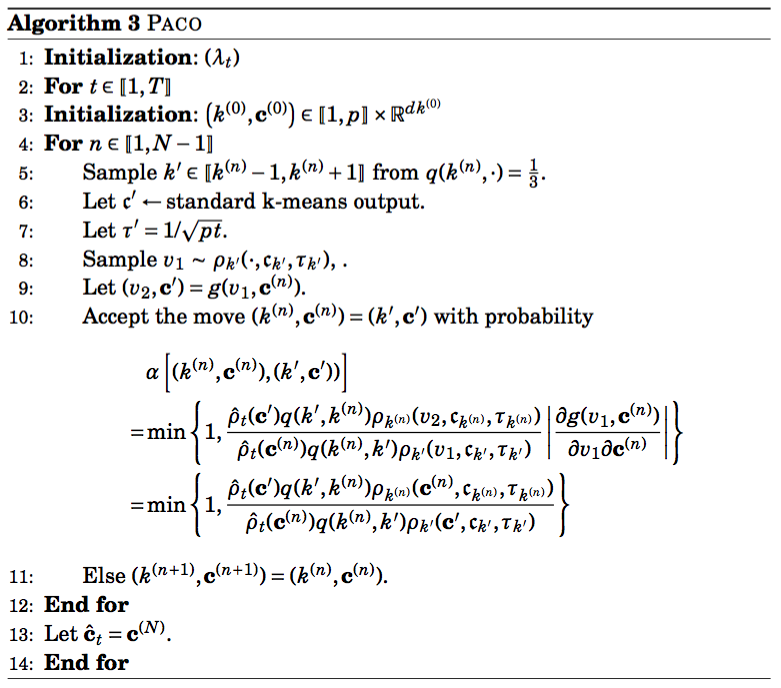

In [1]:
from IPython.display import Image
Image(filename='Algo.png')

In [1]:
import pandas as pd
import numpy as np
from random import randint
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from math import *
from scipy.stats import gamma
import scipy.special as sp

In [126]:
### Funtions needed

# Student's T random variable
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal


def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom

    Edited from: http://stackoverflow.com/a/29804411/3521179
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality
    numerator = sp.gamma(1.0 * (nD + df) / 2.0)
    denominator = (sp.gamma(1.0 * df / 2.0) * np.power(df * np.pi, 1.0 * nD / 2.0) * np.power(np.linalg.det(Sigma), 1.0 / 2.0) * np.power(1.0 + (1.0 / df) * np.diagonal( np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)), 1.0 * (nD + df) / 2.0))
    
    return 1.0 * numerator / denominator 

# Cumulative loss function
def cumulative_loss(centers, observations):
    d = observations.shape[1]
    lth_centers = len(centers)
    size_obs = len(observations)
    C_mtx = np.array([centers for i in range(size_obs)])
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return sum(np.min(Diff,axis = 1))

# Transition probability function
def transition_probability(x, z, K_max, prob = 1/3):
    x = int(x)
    z = int(z)
    K_max = int(K_max)
    if (x > K_max) or (z > K_max) or (x < 1) or (z < 1):
        q = 0
    elif x == 1:
        q = .5*int((z == 1) or (z == 2))
    elif x == K_max:
        q = 0.5*int((z == K_max) or (z == (K_max-1)))
    elif x == z:
        q = prob
    else:
        q = (1-prob)/2 * int(( x < z and z < (x+2)) or (z < x and z > (x-2)))
    return q

# Function to get clusters labels from centroids
def labels_function(centers, observations):
    d = observations.shape[1]
    lth_centers = len(centers)
    size_obs = len(observations)
    C_mtx = np.array([centers for i in range(size_obs)])
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return np.apply_along_axis(lambda x: np.where(x==min(x)), 1, Diff).ravel()

# Function for the prior
def runiform_ball(n, d, R):
    simulations = []
    for i in range(n):
        simul = np.random.uniform(low=-R, high=R, size=d)
        while np.sqrt(sum(simul**2))>R:
            simul = np.random.uniform(low=-R, high=R, size=d)
        simulations.append(simul)
    return np.array(simulations)

# Function for the instantaneous loss
def instantaneous_loss(centers, instant_observation):
    replicate_instant_observation = np.reshape(np.matrix(np.repeat(instant_observation, len(centers))), newshape=(-1,len(centers))).transpose()
    distances = np.power(centers - replicate_instant_observation, 2).sum(axis=1)
    return np.min(distances)



In [127]:
# The X we will use is
data = pd.read_csv('test.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
X = data.as_matrix()

In [185]:
def PACBO(X, R, coeff = 2, K_max = 50, N_iterations = 500):
    d = X.shape[1]
    T = len(X)
    multiplier_R = 1.5
    
    Nclusters = []
    Niter_centers = []
    parameter_means_proposal = []
    sum_loss = np.repeat(0., N_iterations)
    
    # IF 
    
    nb_of_clusters = [1]
    pred_centers = []
    predicted_loss = np.repeat(0., T)
    proposal_loss = np.repeat(0., T)
    
    lambda_1 = np.array([1] + [2.5*coeff*(d+2)*(t-1)**(-0.5)/R for t in range(2,T+1)])
    lambda_2 = np.array([(d+2)*(t)**(-0.5)/(multiplier_R * R)**4 for t in range(1,T+1)])
    
    c_1 = runiform_ball(5000, d, multiplier_R*R)
    
    index_1 = np.array(np.power(c_1 - np.reshape(np.matrix(np.repeat(X[0], 5000)), newshape=(-1,5000)).transpose(), 2).sum(axis=1)).ravel()
    index_1 = np.where(index_1 == instantaneous_loss(c_1, X[0]))[0][0]
    pred_centers.append(c_1[index_1])
    predicted_loss[0] = instantaneous_loss(pred_centers[0], X[0])
    
    for t in range(2,T+1): # t va de 2 à 10
        tau_proposal = (K_max*t*d)**(-0.5)
        
        Nclusters.append(nb_of_clusters[t-2])
        kmeans = KMeans(n_clusters=Nclusters[0], random_state=0, max_iter=10).fit(X[:t-1])
        parameter_means_proposal.append(kmeans.cluster_centers_)
        
        Niter_centers.append(multivariate_t_rvs(parameter_means_proposal[0].ravel(), np.diag([tau_proposal for i in range(d)]), df=3, n=1))
        
        while np.sqrt(sum((Niter_centers[0].ravel()**2))) > multiplier_R * R:
            Niter_centers[0] = multivariate_t_rvs(multivariate_t_rvs(parameter_means_proposal[0].ravel(), np.diag([tau_proposal for i in range(d)]), df=3, n=1))
        
        proposal_loss[:t-1] = list(np.apply_along_axis(lambda x: instantaneous_loss(Niter_centers[0], x), 1, X[:t-1]))
        
        sum_loss[0] = sum(proposal_loss[:(t-1)]) + 0.5 * sum(lambda_2 * (proposal_loss - predicted_loss)**2)
        
        for n in range(2,N_iterations+1):
            proposal_loss_temp = np.repeat(0., T)
            transition_prob = np.array([transition_probability(Nclusters[n-2],Nclusters[n-2]-1,K_max), transition_probability(Nclusters[n-2],Nclusters[n-2],K_max), transition_probability(Nclusters[n-2],Nclusters[n-2]+1,K_max)])
            transition_prob = transition_prob/sum(transition_prob)
            new_k = np.random.choice([Nclusters[n-2]-1,Nclusters[n-2],Nclusters[n-2]+1], p=transition_prob)
            
            if new_k == Nclusters[n-2]:
                m_t = parameter_means_proposal[n-2]
            else:
                if new_k >= t-1:
                    new_k = t-1
                    m_t = X[:t-1]
                else:
                    kmeans = KMeans(n_clusters=int(new_k), random_state=0, max_iter=10).fit(X[:t-1])
                    m_t = kmeans.cluster_centers_




In [204]:
T=10
coeff=2
d=5
R=17.11584
multiplier_R = 1.5
N_iterations = 500
K_max = 50

t = 2
n=2

In [ ]:
PACBO = function(mydata, R, coeff = 2, K_max = 50, scaling = FALSE, var_ind = FALSE, N_iterations = 500, plot_ind = FALSE, axis_ind = c(1,2)){



  #d = length(mydata[1,])
  #T = length(mydata[,1])
  #multiplier_R = 1.5

  #Nclusters = rep(1, N_iterations)
  #Niter_centers = list()
  #parameter_means_proposal = list()
  #sum_loss = rep(0, N_iterations)
    
    # IF
    
  #nb_of_clusters = rep(1, T)
  #pred_centers = list()
  #predicted_loss = rep(0, T)
  #proposal_loss = rep(0, T)

  #lambda_1 = rep(1, T)
  #lambda_1[2:T] = sapply(2:T, function(t) 2.5*coeff *(d+2)*(t-1)^(-0.5)/R)
  #lambda_2 = sapply(1:T, function(t) (d+2)*(t)^(-0.5)/(multiplier_R * R)^4)



  #c_1 = runiform_ball(5000, d, multiplier_R*R)
  #index_1 = which(apply((c_1-t(replicate(5000, mydata[1,])))^2, 1, sum) == instantaneous_loss(c_1, mydata[1,]))
  #pred_centers[[1]] = c_1[index_1,]
  #predicted_loss[1] = instantaneous_loss(pred_centers[[1]], mydata[1,])


  #for (t in 2:T){

    #tau_proposal = (K_max*t*d)^(-0.5)

    #Nclusters[1] = nb_of_clusters[t-1]
    #parameter_means_proposal[[1]] = kmeans(matrix(mydata[1:(t-1),], ncol=d), Nclusters[1], nstart=2, iter.max=10)$centers

    #Niter_centers[[1]] = t(apply(parameter_means_proposal[[1]],1, function(x) rmt(1, mean=x, S = diag(tau_proposal, d), df =3)))


    #while ( sum(sqrt(rowSums((Niter_centers[[1]]^2))) > multiplier_R * R) > 0 ){
    #  Niter_centers[[1]] = t(apply(parameter_means_proposal[[1]],1, function(x) rmt(1, mean=x, S = diag(tau_proposal, d), df =3)))
    #}


    #proposal_loss[1:(t-1)] = apply(matrix(mydata[1:(t-1),], nrow = t-1), 1, function (x) instantaneous_loss(Niter_centers[[1]], x))

    #sum_loss[1] = sum(proposal_loss[1:(t-1)]) + 0.5 * sum(lambda_2 * (proposal_loss - predicted_loss)^2)

    #for (n in 2:N_iterations){
      #proposal_loss_temp = rep(0, T)
      #transition_prob = c(transition_probability(Nclusters[n-1],Nclusters[n-1]-1,K_max), transition_probability(Nclusters[n-1],Nclusters[n-1],K_max), transition_probability(Nclusters[n-1],Nclusters[n-1]+1,K_max))
      #transition_prob = transition_prob/sum(transition_prob)
      #new_k = sample(c(Nclusters[n-1]-1,Nclusters[n-1],Nclusters[n-1]+1),1, prob = transition_prob)
      #if (new_k == Nclusters[n-1]){
      #  m_t = parameter_means_proposal[[n-1]]
      #}else{
      #  if(new_k >= t-1){
      #    new_k = t-1
      #    m_t = matrix(mydata[1:(t-1),], ncol=d, byrow=F)
      #  }else{
      #    m_t = kmeans(matrix(mydata[1:(t-1),],ncol=d), new_k, nstart=2, iter.max=10)$centers
      #  }
      #}
      c_k_prime = t(apply(m_t,1, function(x) rmt(1, mean=x, S = diag(tau_proposal, d), df =3)))

      if (sum( sqrt(rowSums(c_k_prime^2)) < multiplier_R * R ) == new_k) {

        log_numerator_prop = log(apply(matrix(1:Nclusters[n-1], ncol=1),1,function(x) dmt(Niter_centers[[n-1]][x,], mean = parameter_means_proposal[[n-1]][x,], S = diag(tau_proposal,d), df = 3)))

        log_denominator_prop = log(apply(matrix(1:new_k, ncol=1),1,function(x) dmt(c_k_prime[x,], mean=m_t[x,], S = diag(tau_proposal,d), df = 3)))

        log_numerator_prior = rep((log(gamma(d/2+1)) - (d/2)*log(pi) - d*log(multiplier_R*R)), new_k)
        log_denominator_prior = rep((log(gamma(d/2+1)) - (d/2)*log(pi) - d*log(multiplier_R*R)), Nclusters[n-1])


        ln_division = sum(c(log_numerator_prior, log_numerator_prop)-c(log_denominator_prior, log_denominator_prop))


        proposal_loss_temp[1:(t-1)] = apply(matrix(mydata[1:(t-1),], nrow = t-1), 1, function (x) instantaneous_loss(c_k_prime, x))

        s_loss_prime = sum(proposal_loss_temp) + 0.5 * sum(lambda_2 * (proposal_loss_temp - predicted_loss)^2)

        ln_accept_ratio=(-lambda_1[t-1]*(s_loss_prime-sum_loss[n-1]))+ln_division+log(transition_probability(new_k, Nclusters[n-1],K_max))-log(transition_probability(Nclusters[n-1], new_k, K_max))
      }else{
        ln_accept_ratio = log(0)
      }


      bool= (log(runif(1)) < ln_accept_ratio)

      if (bool){
        Niter_centers[[n]] = c_k_prime
        parameter_means_proposal[[n]] = m_t
        Nclusters[n] = new_k
        sum_loss[n] = s_loss_prime
      }else{
        Niter_centers[[n]] = Niter_centers[[n-1]]
        parameter_means_proposal[[n]] = parameter_means_proposal[[n-1]]
        Nclusters[n] = Nclusters[n-1]
        sum_loss[n] = sum_loss[n-1]
      }

    }

    nb_of_clusters[t] = Nclusters[N_iterations]
    pred_centers[[t]]= Niter_centers[[N_iterations]]
    predicted_loss[t] = instantaneous_loss(pred_centers[[t]], mydata[t,])
  }

  labels = labels_function(pred_centers[[T]], mydata)
  if (plot_ind){

    plot(mydata[, axis_ind[1]], mydata[, axis_ind[2]], xlim =c(min(mydata[, axis_ind[1]])-5, max(mydata[, axis_ind[1]])+5), ylim = c(min(mydata[, axis_ind[2]])-5, max(mydata[, axis_ind[2]])+5) , col = 1+labels, xlab = paste(c('axis_'), axis_ind[1], sep = ''), ylab = paste(c('axis_'), axis_ind[2], sep = ''))
    points(pred_centers[[T]][, axis_ind[1]], pred_centers[[T]][, axis_ind[2]], pch = 17, col = 1)
    lgd = c('pred_centers       ', sapply(1:length(unique(labels)), function(x) paste(c('cluster'), as.character(x), sep = ' '), simplify = 'vector'))
    legend('topright', legend = lgd, col = seq(length(unique(labels))+1), pch = c(17, rep(1, length(unique(labels)))), cex = 0.7, xjust = 1)

  }
  return (list('centers' = pred_centers[[T]], 'nb_of_clusters' = nb_of_clusters[T], 'labels' = labels))


In [103]:
def PACO(X, R = max(np.sqrt((X**2).sum(axis=1))), coeff = 2, K_max = 50, scaling = False, N_iterations = 500):
    if type(X) != np.ndarray:
        return 'data should be in matrix type'
    if R < max(np.sqrt((X**2).sum(axis=1))):
        return 'R should be bigger than the maximum Euclidean distance of observations'
    else:
        if scaling == True:
            X = scale(X)
    return X
    
    d = X.shape[1]
    T = len(X)
    multiplier_R = 1.5
    
    Nclusters = np.ones(N_iterations)
    Niter_centers = []
    parameter_means_proposal = []
    sum_loss = np.zeros(N_iterations)
    
    # Here is the code when var_ind = False
    
    lambda_1 = coeff * (d+2)*(T-1)**(-0.5)/R
    tau_proposal = (K_max*T*d)**(-0.5)
    Nclusters[0] = 1
    kmeans = KMeans(n_clusters=Nclusters[0], random_state=0, max_iter=10).fit(X)
    parameter_means_proposal.append(kmeans.cluster_centers_)
    
    Niter_centers.append(multivariate_t_rvs(parameter_means_proposal[0][0], np.diag([tau_proposal for i in range(d)]), df=3, n=1))
    
    while np.sqrt(sum((Niter_centers[0][0]**2))) > multiplier_R * R:
        Niter_centers[0] = multivariate_t_rvs(parameter_means_proposal[0][0], np.diag([tau_proposal for i in range(d)]), df=3, n=1)
    
    sum_loss[0] = cumulative_loss(Niter_centers[0], X)
    
    for n in range(1,N_iterations):
        transition_prob = np.array([transition_probability(Nclusters[n-1],Nclusters[n-1]-1,K_max),
                                   transition_probability(Nclusters[n-1],Nclusters[n-1],K_max),
                                   transition_probability(Nclusters[n-1],Nclusters[n-1]+1,K_max)])
        transition_prob = transition_prob/sum(transition_prob)
        
        new_k = np.random.choice([Nclusters[n-1]-1,Nclusters[n-1],Nclusters[n-1]+1], p=transition_prob)
        if new_k == Nclusters[n-1]:
            m_t = parameter_means_proposal[n-1]
        else:
            if new_k >= T:
                new_k = T
                m_t = X
            else:
                kmeans = KMeans(n_clusters=int(new_k), random_state=0, max_iter=10).fit(X)
                m_t = kmeans.cluster_centers_
        
        c_k_prime = np.array([multivariate_t_rvs(i, np.diag([tau_proposal for i in range(d)]), df=3, n=1).ravel() for i in m_t])
        
        if sum(np.sqrt(np.sum(c_k_prime**2, axis = 1)) < multiplier_R * R ) == new_k:
            
            eval_grid_Ncluster = np.reshape(np.array([i for i in range(1, int(Nclusters[n-1]+1))]), newshape=(-1, 1))
            log_numerator_prop = np.log(multivariate_t_distribution(eval_grid_Ncluster, parameter_means_proposal[n-1], np.diag([tau_proposal for i in range(d)]), 3))
            
            eval_grid_new_k = np.reshape(np.array([i for i in range(1, int(new_k+1))]), newshape=(-1, 1))
            log_denominator_prop = np.log(multivariate_t_distribution(eval_grid_new_k, m_t, np.diag([tau_proposal for i in range(d)]), 3))
                
            log_numerator_prior = np.repeat((log(sp.gamma(d/2+1)) - (d/2)*log(pi) - d*log(multiplier_R*R)), new_k)
            log_denominator_prior = np.repeat((log(sp.gamma(d/2+1)) - (d/2)*log(pi) - d*log(multiplier_R*R)), Nclusters[n-1])
            
            ln_division = (log_numerator_prior-log_denominator_prior).sum() + (log_numerator_prop-log_denominator_prop).sum()
            
            s_loss_prime = cumulative_loss(c_k_prime, mydata)
            
            ln_accept_ratio = (-lambda_1*(s_loss_prime-sum_loss[n-1]))+ln_division+np.log(transition_probability(new_k, Nclusters[n-1],K_max))-np.log(transition_probability(Nclusters[n-1], new_k, K_max))
        else:
            ln_accept_ratio = log(0)
        if log(np.random.uniform()) < ln_accept_ratio:
            Niter_centers.append(c_k_prime)
            parameter_means_proposal.append(m_t)
            Nclusters[n] = new_k
            sum_loss[n] = s_loss_prime
        else:
            Niter_centers.append(Niter_centers[n-1])
            parameter_means_proposal.append(parameter_means_proposal[n-1])
            Nclusters[n] = Nclusters[n-1]
            sum_loss[n] = sum_loss[n-1]
            
    pred_centers = Niter_centers[N_iterations-1]
    nb_clusters = Nclusters[N_iterations-1]
    labels = labels_function(pred_centers, X)
    
    return pd.DataFrame({'predicted_centers': pred_centers, 'nb_of_clusters': nb_clusters, 'labels': labels})

### Dataviz for PACO algorithm

In [12]:
nb_clusters = pd.read_csv('nb_clusters', index_col='Unnamed: 0')

In [13]:
nb_clusters

,x
1,1
2,1
3,2
4,3
5,4
6,3
7,3
8,3
9,4
10,4


In [14]:
data_labels = pd.read_csv('data_and_labels', index_col='Unnamed: 0')

In [15]:
data_labels

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
1,3.936169,-5.236498,-3.798071,-1.625688,3.216194,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3
2,-4.233532,-4.335694,0.132634,-6.562040,-1.067104,NaN,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2
3,-2.901115,-4.868530,2.242835,-9.376464,-1.475363,NaN,NaN,2.0,3.0,3.0,1.0,1.0,2.0,1.0,2
4,2.730874,6.485581,-4.145847,-2.121356,7.008397,NaN,NaN,NaN,1.0,4.0,2.0,2.0,1.0,3.0,1
5,2.135514,7.506054,-3.884702,-2.476443,7.089433,NaN,NaN,NaN,NaN,4.0,2.0,2.0,1.0,3.0,1
6,4.445837,-4.937555,-2.951132,-1.407294,2.029035,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,3
7,2.701982,-5.284425,-3.656560,-2.940457,3.525030,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,4.0,3
8,-2.203241,5.800990,-4.332187,1.110037,-4.697293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,4
9,-0.235401,7.114460,-3.303405,-0.847189,-5.993319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4
10,-4.106674,-4.915394,0.667565,-6.290378,-0.499180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
